# Task 2: Time Series Forecasting Models

## Tesla's Stock Price Prediction

This task involves building a time series forecasting model to predict Tesla's future stock prices. Below are the step-by-step instructions to develop, evaluate, and refine a forecasting model using common techniques such as **ARIMA**, **SARIMA**, or **LSTM**.

### Step-by-Step Instructions:

#### 1. Choose a Model:
- **ARIMA (AutoRegressive Integrated Moving Average):**  
  Suitable for univariate time series with no seasonality.
- **SARIMA (Seasonal ARIMA):**  
  Extends ARIMA by considering seasonality.
- **LSTM (Long Short-Term Memory):**  
  A type of recurrent neural network (RNN) well-suited for capturing long-term dependencies in time series data.

#### 2. Split the Dataset:
- Divide the dataset into **training** and **testing** sets to evaluate model performance.

#### 3. Train the Model:
- Train the chosen model on the **training set**.

#### 4. Forecast Future Stock Prices:
- Use the model to forecast future stock prices.
- Compare the predictions with the **testing set**.

#### 5. Optimize Model Parameters:
- techniques like **grid search** or **auto_arima** from the `pmdarima` library to find the best `(p, d, q)` parameters.

#### 6. Evaluate Model Performance:
- Calculate evaluation metrics to assess the model's performance:
  - **Mean Absolute Error (MAE)**
  - **Root Mean Squared Error (RMSE)**
  - **Mean Absolute Percentage Error (MAPE)**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from scripts.time_series_forecasting import *

In [4]:
# Load the preprocessed data
df_TSLA = pd.read_csv('../data/processed/TSLA_processed.csv')

In [5]:
df_TSLA.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,MA20,MA50,MA200,Volatility
0,2015-01-02 00:00:00-05:00,14.858000,14.883333,14.217333,14.620667,71466000,0.0,0.0,0.001910,112.066128,111.844028,111.726126,0.522614
1,2015-01-05 00:00:00-05:00,14.303333,14.433333,13.810667,14.006000,80527500,0.0,0.0,-0.042041,112.066128,111.844028,111.726126,0.522614
2,2015-01-06 00:00:00-05:00,14.004000,14.280000,13.614000,14.085333,93928500,0.0,0.0,0.005664,112.066128,111.844028,111.726126,0.522614
3,2015-01-07 00:00:00-05:00,14.223333,14.318667,13.985333,14.063333,44526000,0.0,0.0,-0.001562,112.066128,111.844028,111.726126,0.522614
4,2015-01-08 00:00:00-05:00,14.187333,14.253333,14.000667,14.041333,51637500,0.0,0.0,-0.001564,112.066128,111.844028,111.726126,0.522614


In [6]:
df_TSLA['Date'] = pd.to_datetime(df_TSLA['Date'],utc=True).dt.date
df_TSLA.set_index('Date', inplace=True)

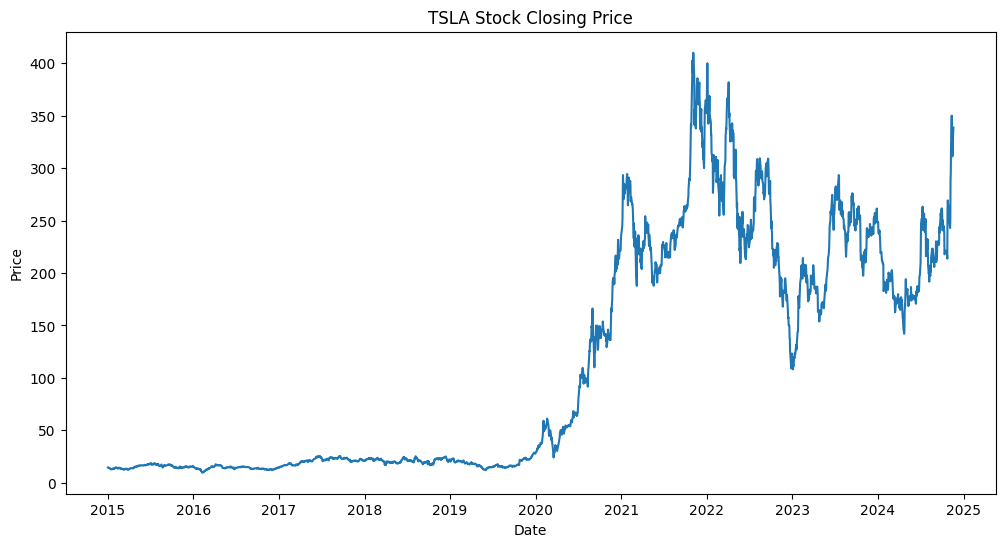

In [7]:
# Stock Closing Price
df_TSLA['Close'].plot(figsize=(12, 6), title="TSLA Stock Closing Price", xlabel='Date', ylabel='Price')
plt.show()

seasonal decomposition

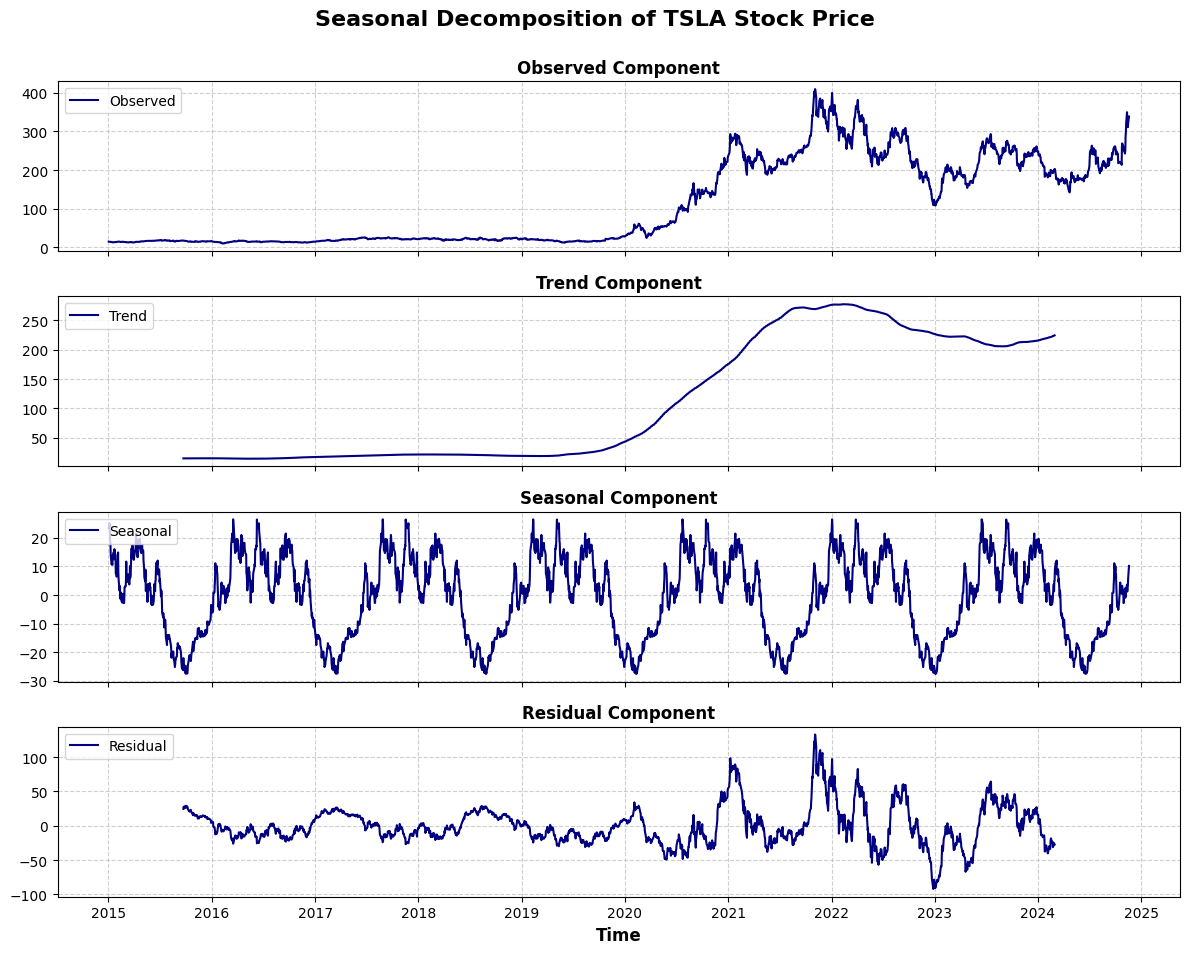

In [8]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df_TSLA['Close'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot each component separately
components = ['Observed', 'Trend', 'Seasonal', 'Residual']
plots = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]

for ax, component, data in zip(axes, components, plots):
    ax.plot(data, label=component, color='navy', linewidth=1.5)
    ax.set_title(f"{component} Component", fontsize=12, fontweight='bold')
    ax.grid(visible=True, linestyle='--', alpha=0.6)
    ax.legend(loc="upper left")

plt.xlabel("Time", fontsize=12, fontweight='bold')
fig.suptitle("Seasonal Decomposition of TSLA Stock Price", fontsize=16, fontweight='bold', y=0.95)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()


ADF test for stationarity 

In [9]:
# Perform ADF test for stationarity 
adf_test(df_TSLA['Close'], 'TSLA')

ADF Test for TSLA:
ADF Statistic: -0.741545404358219
p-value: 0.8356929377286852



ACF  and PACF for TSLA Close price

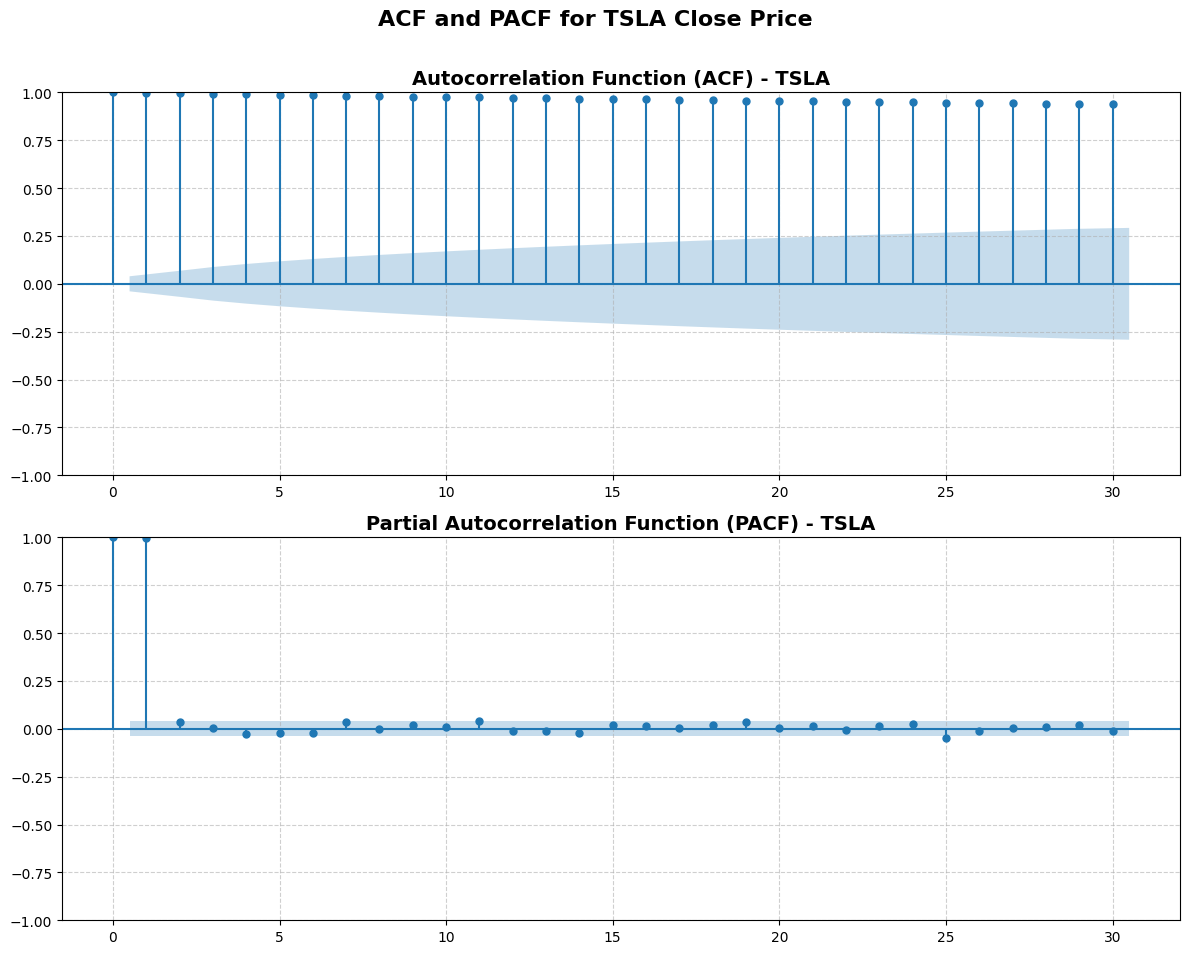

In [10]:
# Create a single figure for ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot ACF for TSLA Close price
plot_acf(df_TSLA['Close'], ax=ax[0], lags=30)
ax[0].set_title("Autocorrelation Function (ACF) - TSLA", fontsize=14, fontweight='bold')
ax[0].grid(visible=True, linestyle='--', alpha=0.6)

# Plot PACF for TSLA Close price
plot_pacf(df_TSLA['Close'], ax=ax[1], lags=30, method='ywm')
ax[1].set_title("Partial Autocorrelation Function (PACF) - TSLA", fontsize=14, fontweight='bold')
ax[1].grid(visible=True, linestyle='--', alpha=0.6)

# Add a main title for the figure
fig.suptitle("ACF and PACF for TSLA Close Price", fontsize=16, fontweight='bold', y=0.95)

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


In [11]:
# Check for missing values and fill them for TSLA data
print("Missing values in TSLA:")
print(df_TSLA.isnull().sum())

# Fill missing values (if any)
df_TSLA.fillna(method='ffill', inplace=True)
df_TSLA.fillna(method='bfill', inplace=True)  # Optionally fill backward if leading NaNs exist

# Extract 'Close' prices for TSLA after filling missing values
tsla_close = df_TSLA['Close']

#  Scale or normalize TSLA ' Close' prices
# Example: min-max scaling
tsla_close_scaled = (tsla_close - tsla_close.min()) / (tsla_close.max() - tsla_close.min())

print("TSLA data preparation complete.")


Missing values in TSLA:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Daily_Return    0
MA20            0
MA50            0
MA200           0
Volatility      0
dtype: int64
TSLA data preparation complete.


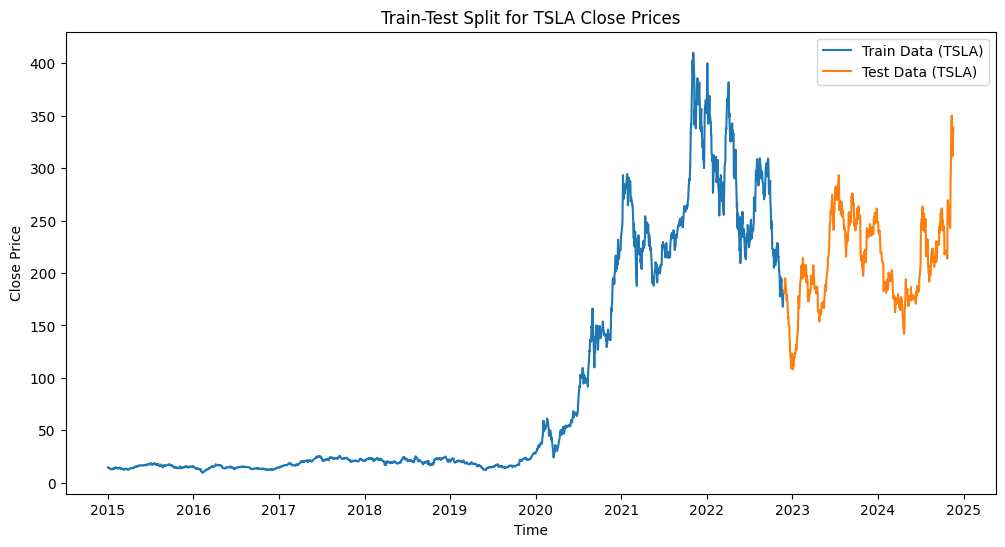

In [12]:
# Define the split ratio
split_ratio = 0.8
train_size = int(len(tsla_close) * split_ratio)

# Split the data for TSLA
tsla_train, tsla_test = tsla_close[:train_size], tsla_close[train_size:]

# Plot Train-Test Split for TSLA
plt.figure(figsize=(12, 6))
plt.plot(tsla_train, label='Train Data (TSLA)')
plt.plot(tsla_test, label='Test Data (TSLA)')
plt.legend()
plt.title("Train-Test Split for TSLA Close Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()


### ARIMA MODEL 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12419.170, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12414.872, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12413.619, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12413.701, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12413.347, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12415.171, Time=0.53 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.637 seconds
Optimal (p, d, q) parameters: (0, 1, 0)


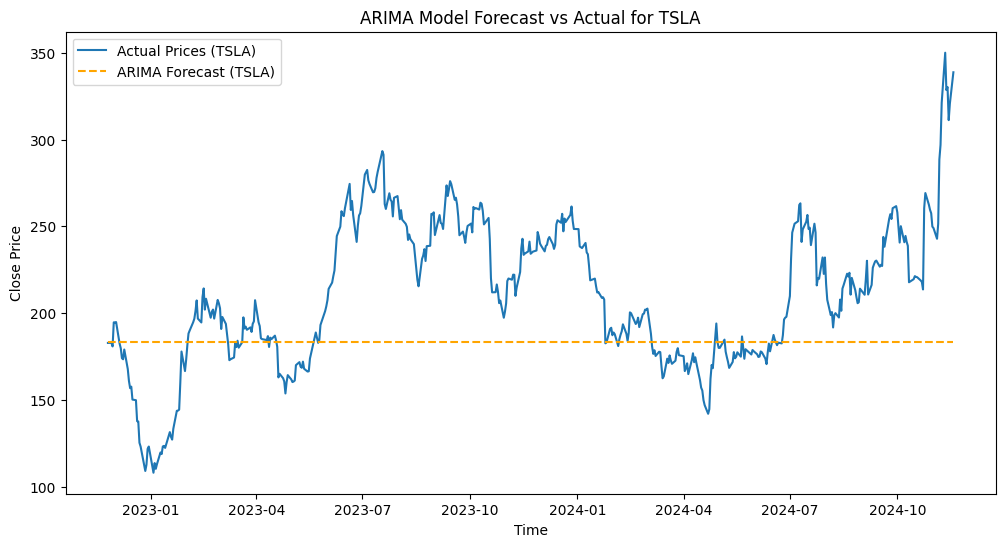

In [13]:
# Apply ARIMA for TSLA
arima_forecast, tsla_test, model_arima_fit = apply_arima(tsla_train, tsla_test)


# Plot actual vs ARIMA forecast for TSLA
plt.figure(figsize=(12, 6))
plt.plot(tsla_test.index, tsla_test.values, label='Actual Prices (TSLA)')
plt.plot(tsla_test.index, arima_forecast, label='ARIMA Forecast (TSLA)', linestyle='--', color='orange')

# Add title and legend
plt.title("ARIMA Model Forecast vs Actual for TSLA")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

Residual Analysis Plot
    residuals (difference between actual and forecasted values) to check for pattern.

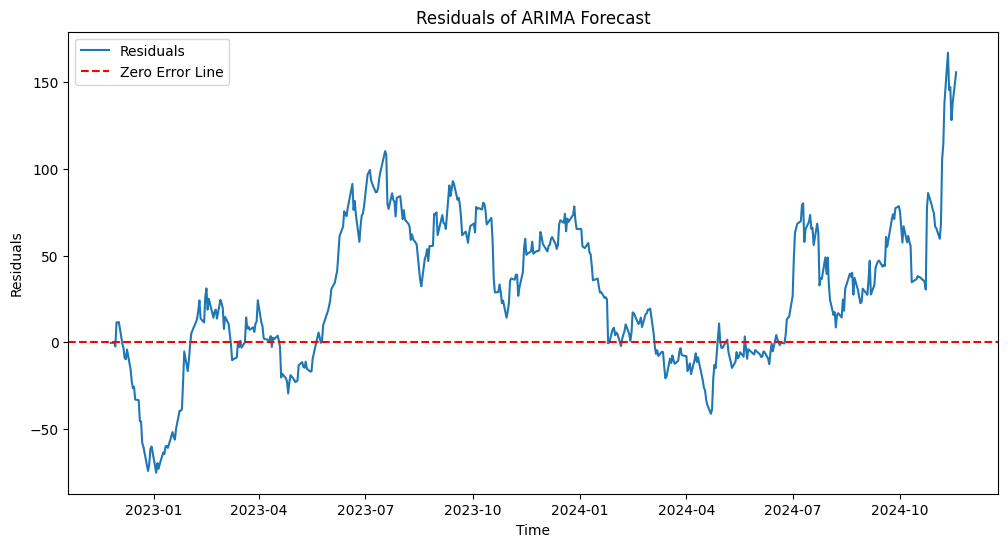

In [14]:
residuals = tsla_test.values - arima_forecast
plt.figure(figsize=(12, 6))
plt.plot(tsla_test.index, residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')
plt.title("Residuals of ARIMA Forecast")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()


ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) Plots to understand whether residuals are white noise and whether any autocorrelation remains.

<Figure size 1200x600 with 0 Axes>

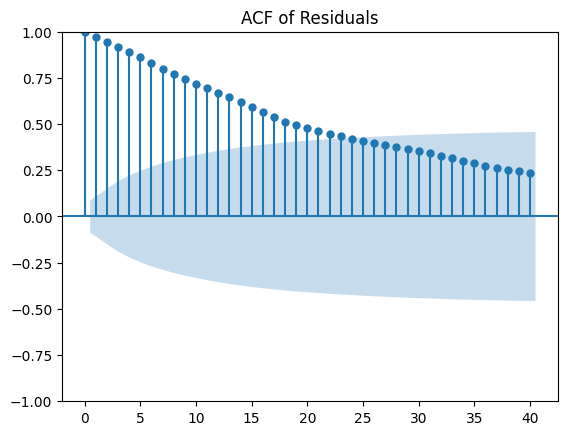

<Figure size 1200x600 with 0 Axes>

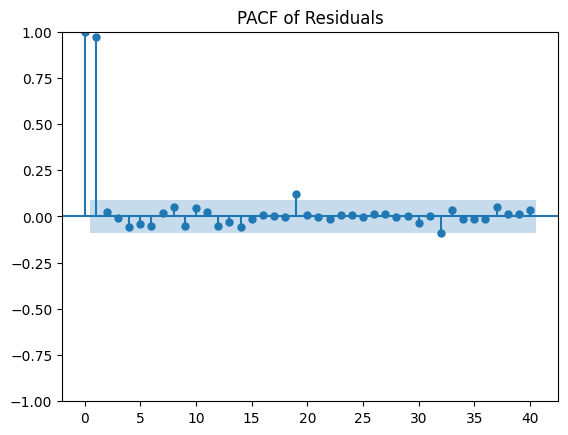

In [15]:
# ACF and PACF of residuals
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=40, title='ACF of Residuals')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(residuals, lags=40, title='PACF of Residuals')
plt.show()

In-sample Fit

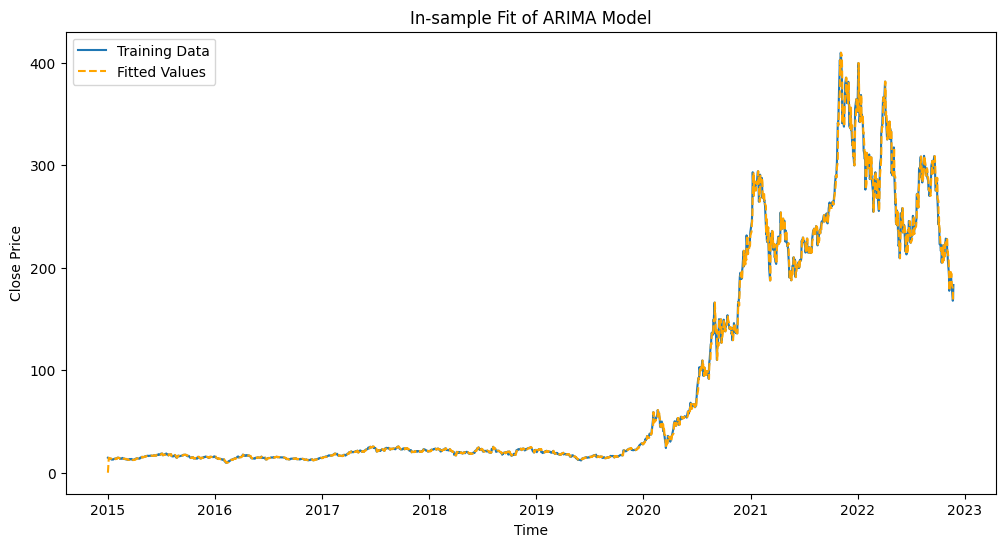

In [16]:
fitted_values = model_arima_fit.fittedvalues
plt.figure(figsize=(12, 6))
plt.plot(tsla_train.index, tsla_train.values, label='Training Data')
plt.plot(tsla_train.index, fitted_values, label='Fitted Values', linestyle='--', color='orange')
plt.title("In-sample Fit of ARIMA Model")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

Forecast with Prediction Intervals 

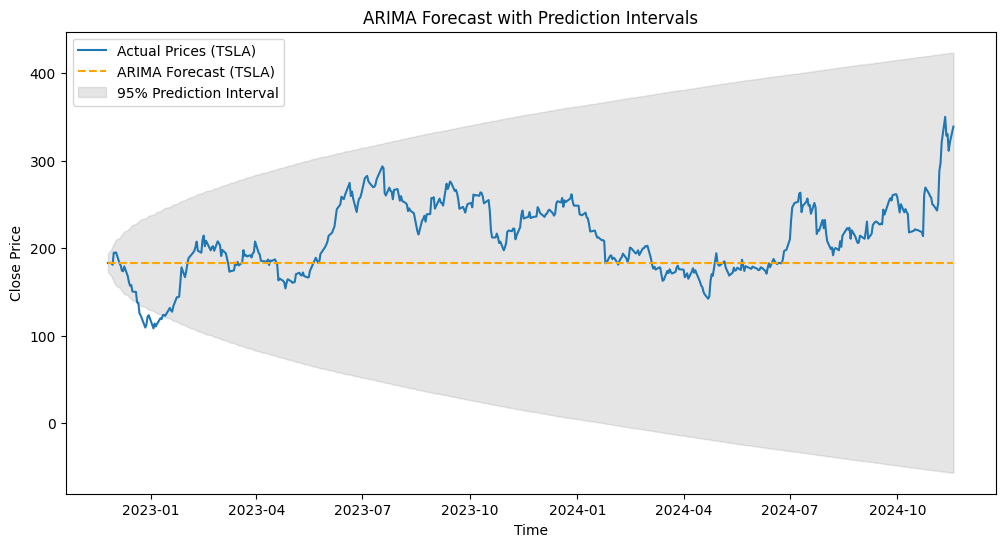

In [17]:
# Get forecast with confidence intervals
forecast_object = model_arima_fit.get_forecast(steps=len(tsla_test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05)  # 95% prediction interval

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(tsla_test.index, tsla_test.values, label='Actual Prices (TSLA)')
plt.plot(tsla_test.index, forecast, label='ARIMA Forecast (TSLA)', linestyle='--', color='orange')
plt.fill_between(tsla_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Prediction Interval')
plt.title("ARIMA Forecast with Prediction Intervals")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

Distribution of Residuals 

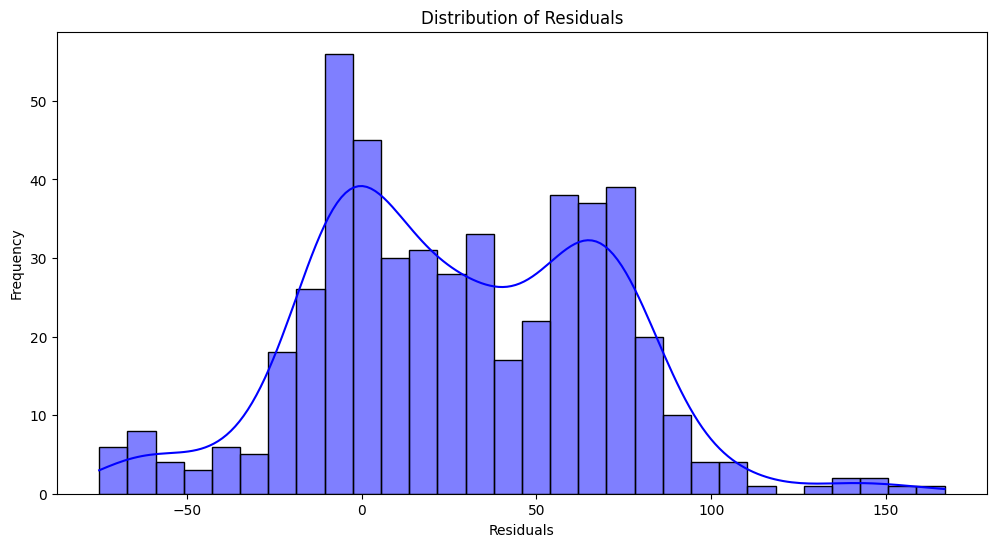

In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

ARIMA model’s diagnostic plots to check for heteroscedasticity, normality, and autocorrelation.

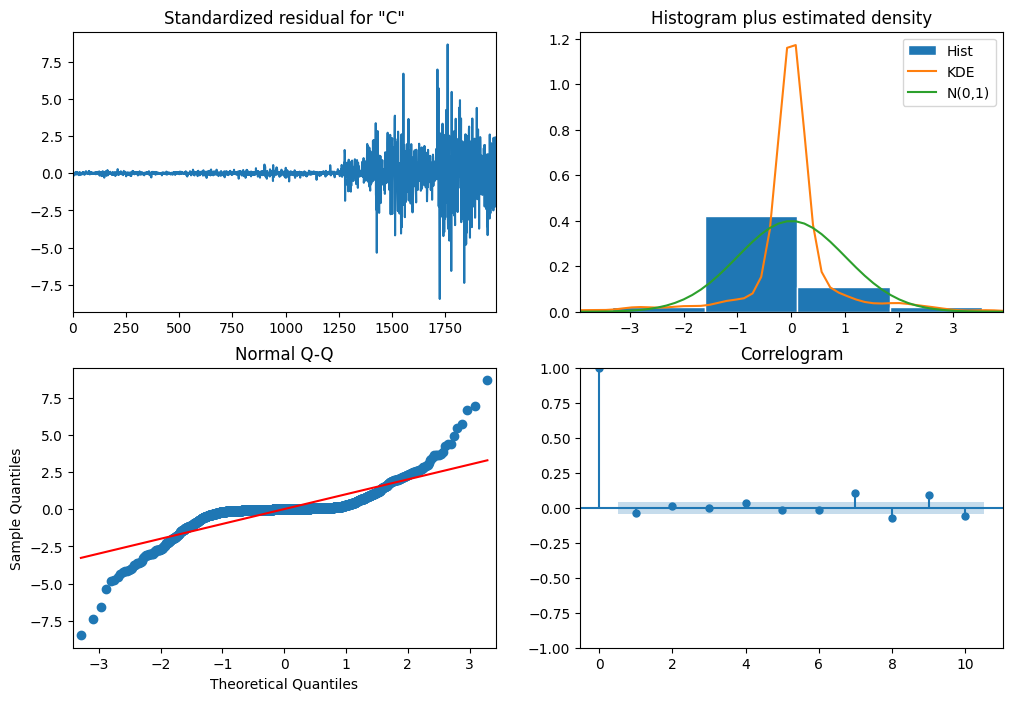

In [19]:
model_arima_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

Rolling Mean and Standard Deviation

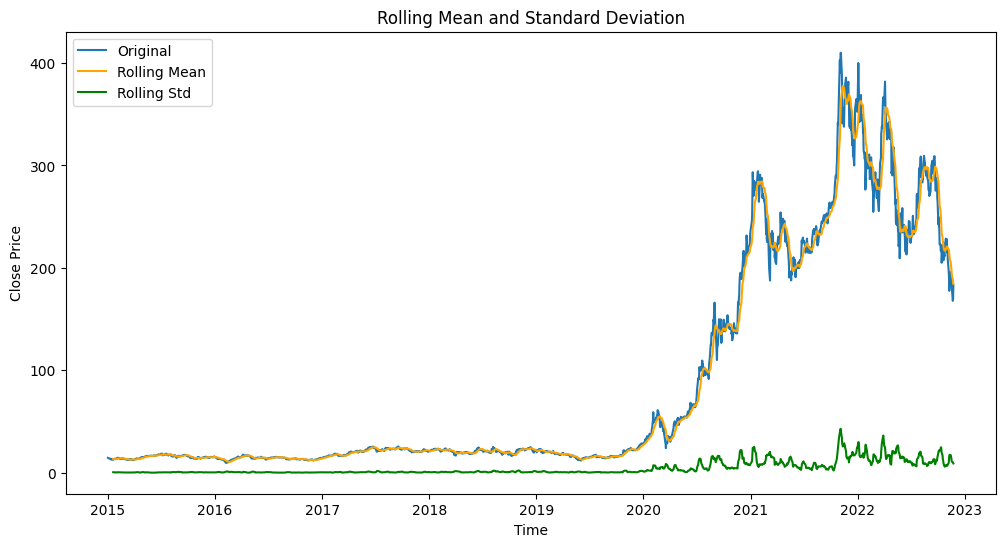

In [20]:
rolling_mean = tsla_train.rolling(window=12).mean()
rolling_std = tsla_train.rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(tsla_train, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title("Rolling Mean and Standard Deviation")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

### SARIMA MODEL 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12414.872, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12414.060, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12414.463, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12413.347, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=12415.284, Time=0.32 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=12415.598, Time=0.32 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=12408.917, Time=0.65 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=12407.969, Time=0.92 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=12414.367, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=12413.619, Time=0.09 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=12409.248, Time=1.39 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=12408.912, Time=2.97 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=12408.080, Time=1.66 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=12410.870, Time=3.38 sec
 ARIM

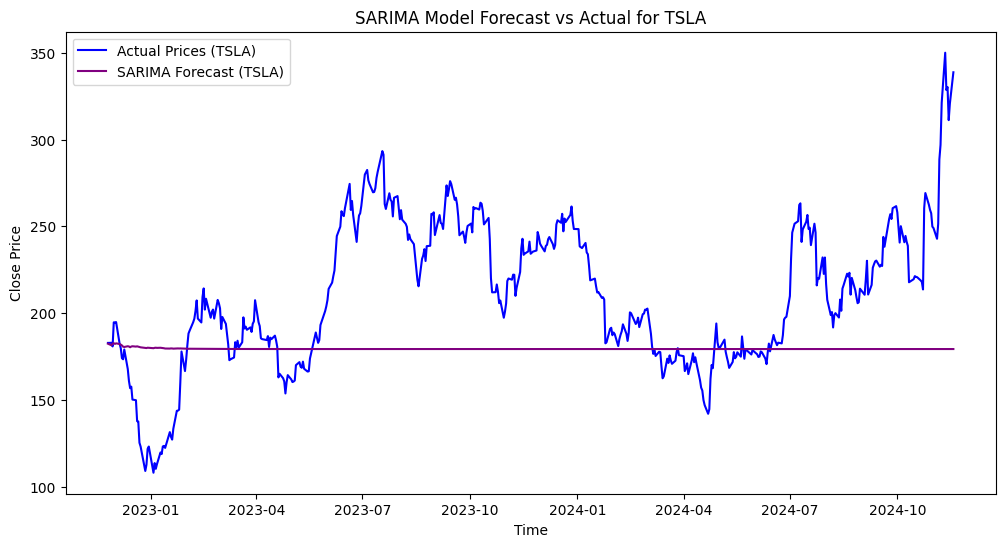

In [21]:
# SARIMA modeling for TSLA
# Automatically find the optimal SARIMA parameters with restricted search space
sarima_model_tsla = pm.auto_arima(
    tsla_train,
    seasonal=True,
    m=12,
    start_p=0, max_p=2,    # Restrict p parameters
    start_q=0, max_q=2,    # Restrict q parameters
    start_P=0, max_P=1,    # Restrict seasonal P parameters
    start_Q=0, max_Q=1,    # Restrict seasonal Q parameters
    max_d=1,               # Restrict differencing
    max_D=1,               # Restrict seasonal differencing
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,         # Use stepwise search instead of grid search
    n_fits=10             # Limit number of models to evaluate
)

print(f"Optimal SARIMA parameters for TSLA: {sarima_model_tsla.order}x{sarima_model_tsla.seasonal_order}")

# Fit the SARIMA model with optimized settings
model_sarima_tsla = SARIMAX(
    tsla_train,
    order=sarima_model_tsla.order,
    seasonal_order=sarima_model_tsla.seasonal_order,
    enforce_stationarity=False,    # Speed up fitting
    enforce_invertibility=False    # Speed up fitting
)

# Fit with optimized solver settings
model_sarima_fit_tsla = model_sarima_tsla.fit(
    disp=False,
    method='lbfgs',    # Faster optimization algorithm
    maxiter=50         # Limit maximum iterations
)

# Forecast for the test period
sarima_forecast_tsla = model_sarima_fit_tsla.forecast(steps=len(tsla_test))

# Plot actual vs SARIMA forecast for TSLA
plt.figure(figsize=(12, 6))
plt.plot(tsla_test, label='Actual Prices (TSLA)', color='blue')
plt.plot(tsla_test.index, sarima_forecast_tsla, label='SARIMA Forecast (TSLA)', color='purple')
plt.legend()
plt.title("SARIMA Model Forecast vs Actual for TSLA")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

 Residuals

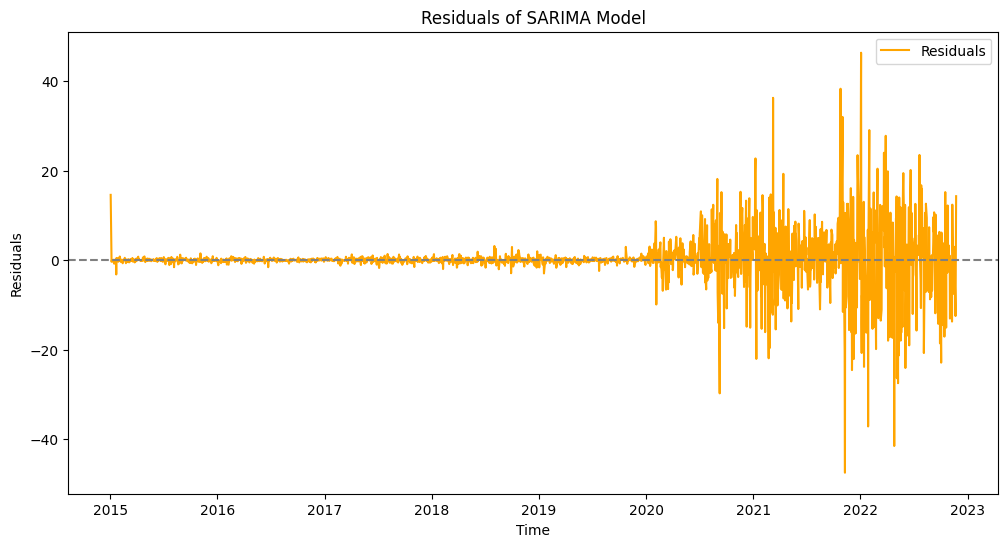

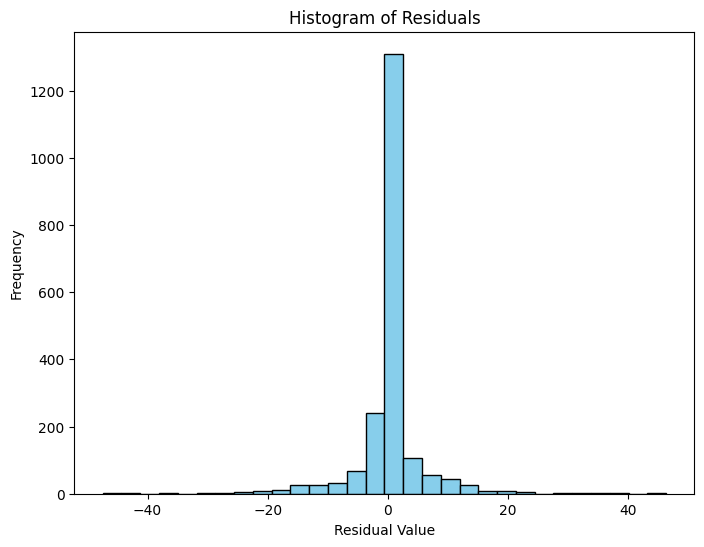

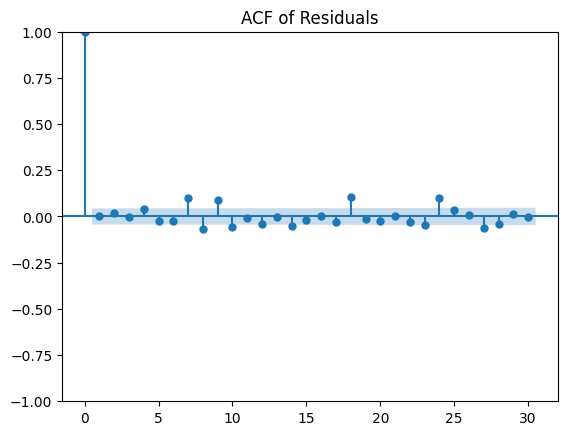

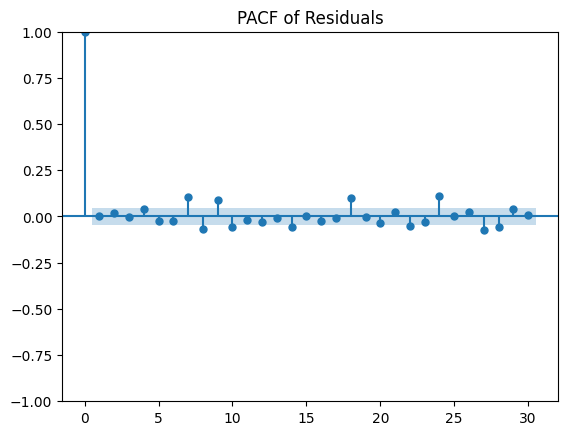

In [22]:
# Residuals
residuals = model_sarima_fit_tsla.resid

# Plot residuals time series
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals", color="orange")
plt.axhline(0, linestyle="--", color="gray")
plt.title("Residuals of SARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()

# ACF and PACF of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

plot_pacf(residuals, lags=30)
plt.title("PACF of Residuals")
plt.show()


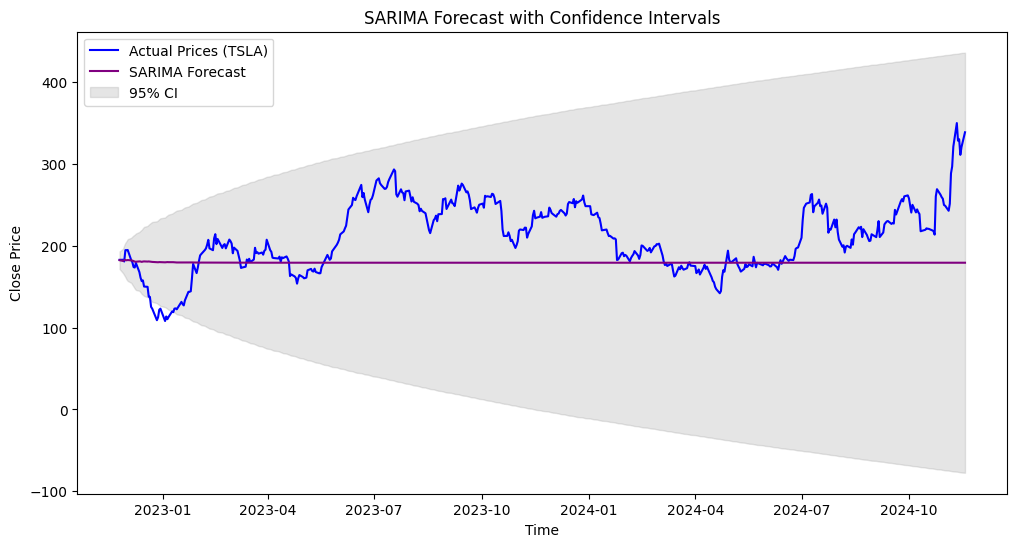

In [23]:
# Get forecast with confidence intervals
forecast_object = model_sarima_fit_tsla.get_forecast(steps=len(tsla_test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

# Plot forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(tsla_test, label="Actual Prices (TSLA)", color="blue")
plt.plot(tsla_test.index, forecast, label="SARIMA Forecast", color="purple")
plt.fill_between(tsla_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color="gray", alpha=0.2, label="95% CI")
plt.legend()
plt.title("SARIMA Forecast with Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

Sarima Model Diagnostics 

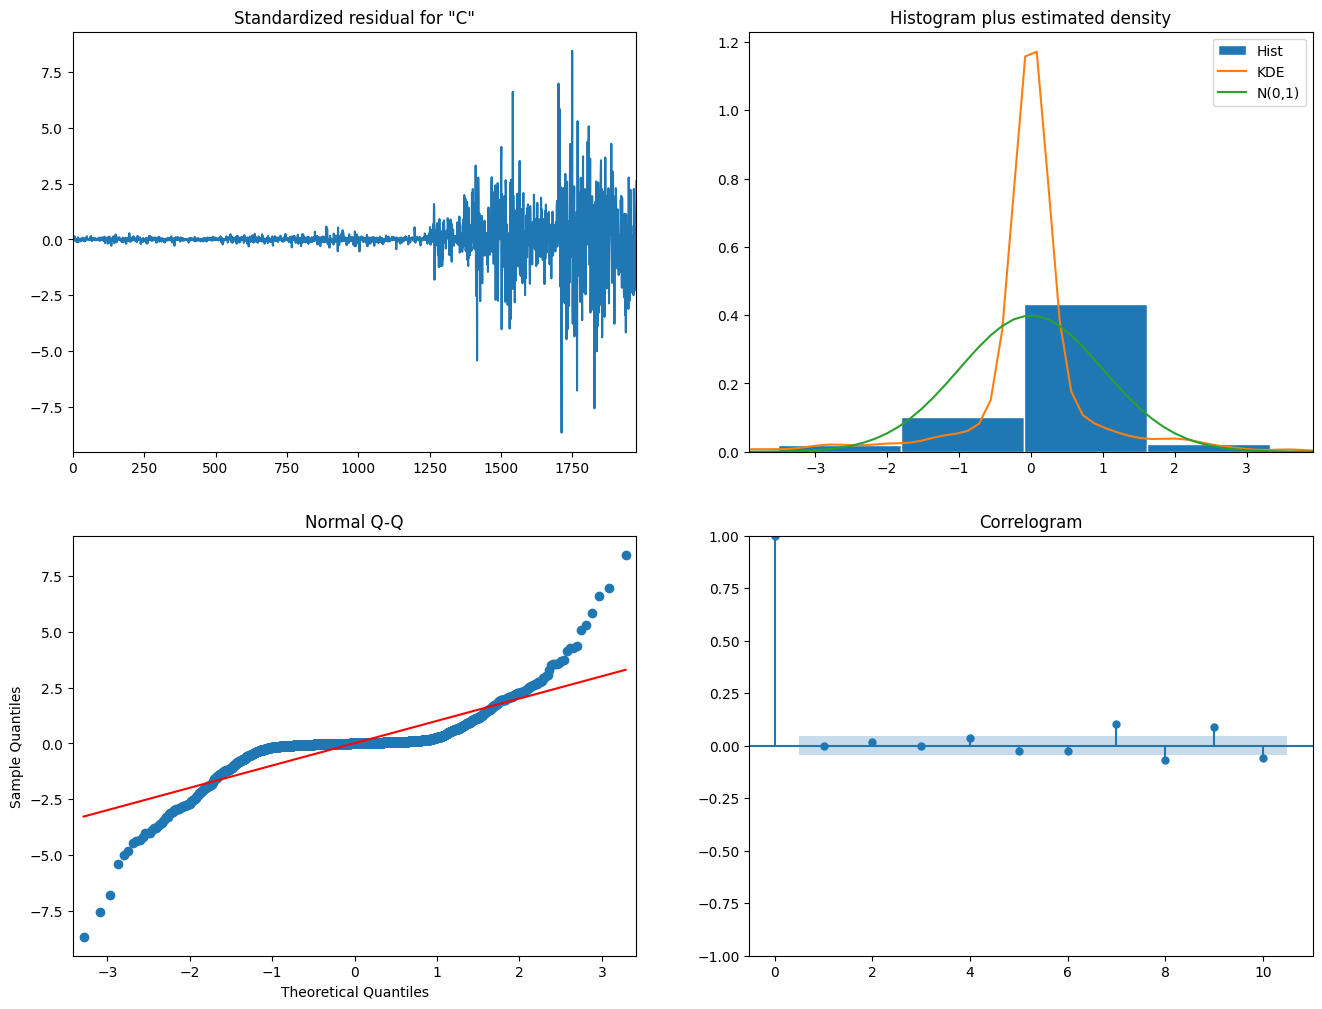

In [24]:
# Model diagnostics
model_sarima_fit_tsla.plot_diagnostics(figsize=(16, 12))
plt.show()

In [25]:
mae = mean_absolute_error(tsla_test, sarima_forecast_tsla)
rmse = np.sqrt(mean_squared_error(tsla_test, sarima_forecast_tsla))
mape = np.mean(np.abs((tsla_test - sarima_forecast_tsla) / tsla_test)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 40.72278081227946
Root Mean Squared Error (RMSE): 51.981065786606564
Mean Absolute Percentage Error (MAPE): nan%


In [26]:
# Generate forecast and confidence intervals
forecast_object = model_sarima_fit_tsla.get_forecast(steps=len(tsla_test))
conf_intervals = forecast_object.conf_int()

# Rename columns for clarity
conf_intervals.columns = ['Lower Close', 'Upper Close']

# Display the confidence intervals as a table
print(conf_intervals)


      Lower Close  Upper Close
1989   171.662355   193.179328
1990   166.584693   196.433383
1991   164.211802   200.546815
1992   161.793288   203.619964
1993   158.965171   205.641830
...           ...          ...
2482   -76.265588   434.934055
2483   -76.526528   435.194995
2484   -76.787202   435.455669
2485   -77.047611   435.716078
2486   -77.307756   435.976222

[498 rows x 2 columns]


### LSTM MODEL 

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.0449e-04
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.9207e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.4603e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.0396e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.4245e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.0754e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.1469e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.4708e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.1908e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.9924e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.3058e-04
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.6329e-04
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.1335e-04
Epoch 14/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.9542e-04
Epoch 15/50
61/

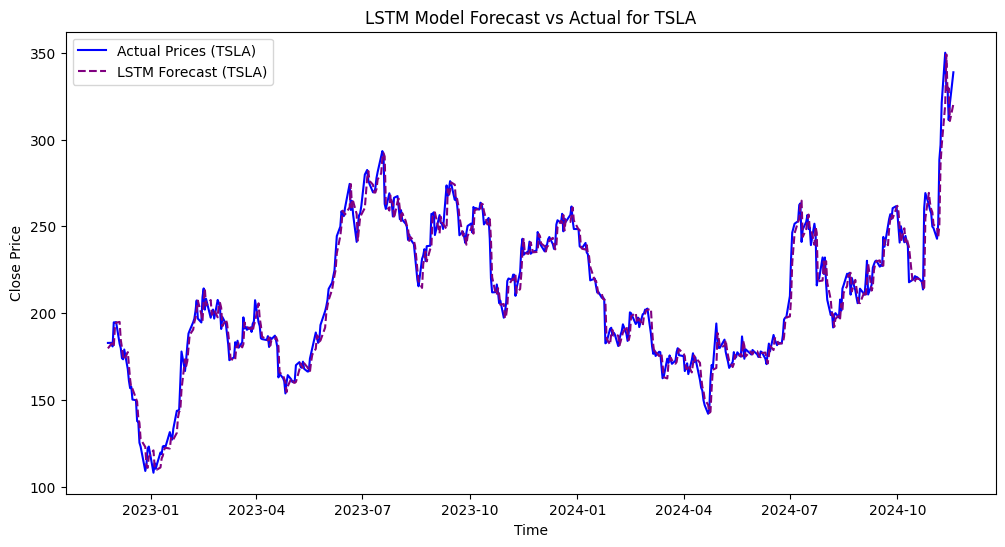

In [27]:
# Apply LSTM to TSLA data
scaler, X_train, y_train, X_test, tsla_test = prepare_lstm_data(tsla_train, tsla_test)

# Build, train, and predict with the LSTM model
model_lstm = build_lstm_model(X_train)
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
lstm_forecast = train_and_predict_lstm(model_lstm, X_train, y_train, X_test)

# Inverse transform predictions to original scale
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# Plot actual vs LSTM forecast for TSLA
plt.figure(figsize=(12, 6))
plt.plot(tsla_test.index, tsla_test.values, label='Actual Prices (TSLA)', color='blue')
plt.plot(tsla_test.index, lstm_forecast, label='LSTM Forecast (TSLA)', linestyle='--', color='purple')
plt.title("LSTM Model Forecast vs Actual for TSLA")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

LSTM Training Loss 

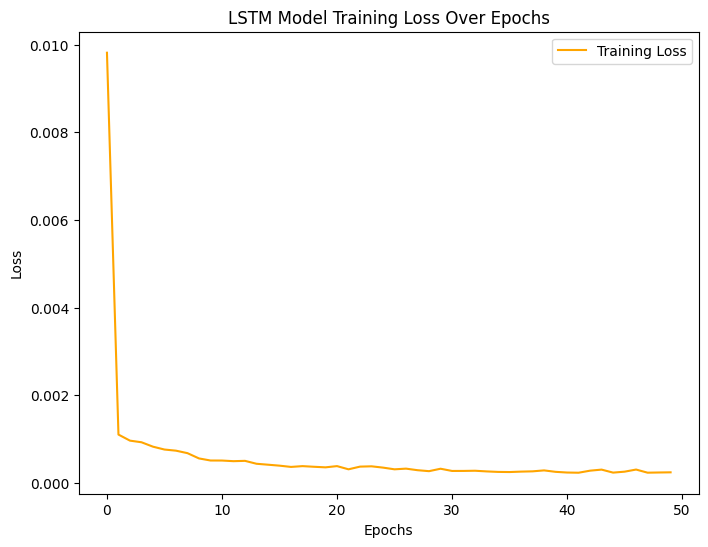

In [28]:
# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title("LSTM Model Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

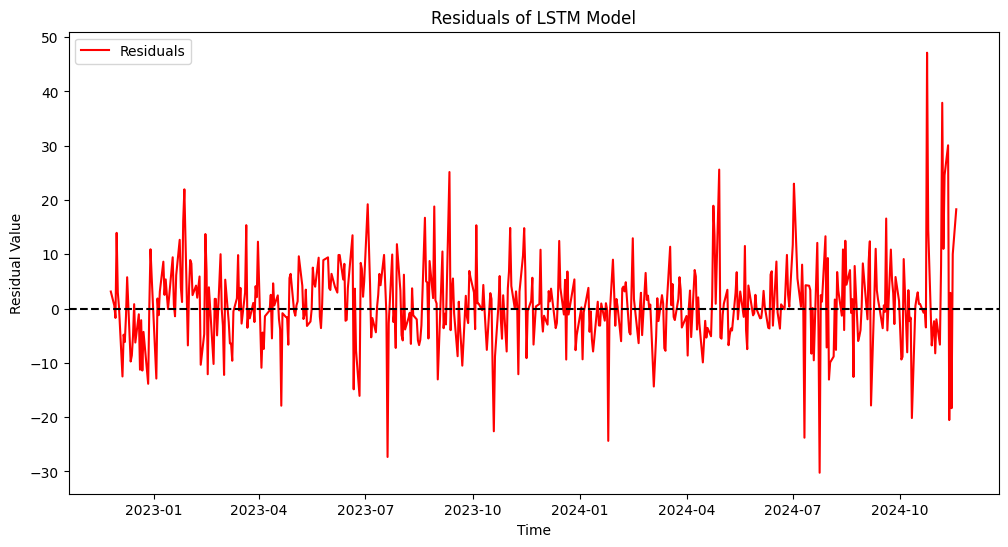

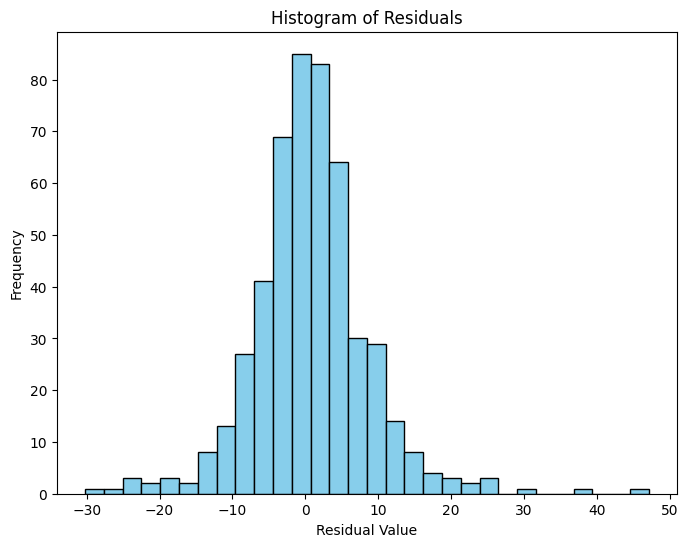

In [29]:
# Residuals
residuals = tsla_test.values - lstm_forecast.flatten()

# Plot residuals time series
plt.figure(figsize=(12, 6))
plt.plot(tsla_test.index, residuals, label="Residuals", color="red")
plt.axhline(0, linestyle="--", color="black")
plt.title("Residuals of LSTM Model")
plt.xlabel("Time")
plt.ylabel("Residual Value")
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()


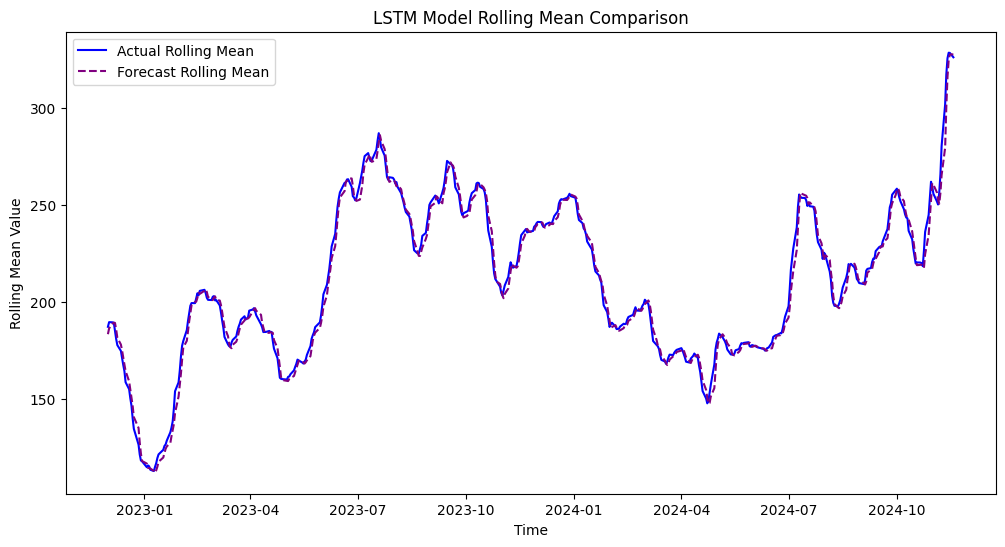

In [30]:
# Rolling means
actual_rolling = tsla_test.rolling(window=5).mean()
forecast_rolling = pd.Series(lstm_forecast.flatten(), index=tsla_test.index).rolling(window=5).mean()

plt.figure(figsize=(12, 6))
plt.plot(tsla_test.index, actual_rolling, label="Actual Rolling Mean", color="blue")
plt.plot(tsla_test.index, forecast_rolling, label="Forecast Rolling Mean", linestyle="--", color="purple")
plt.title("LSTM Model Rolling Mean Comparison")
plt.xlabel("Time")
plt.ylabel("Rolling Mean Value")
plt.legend()
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


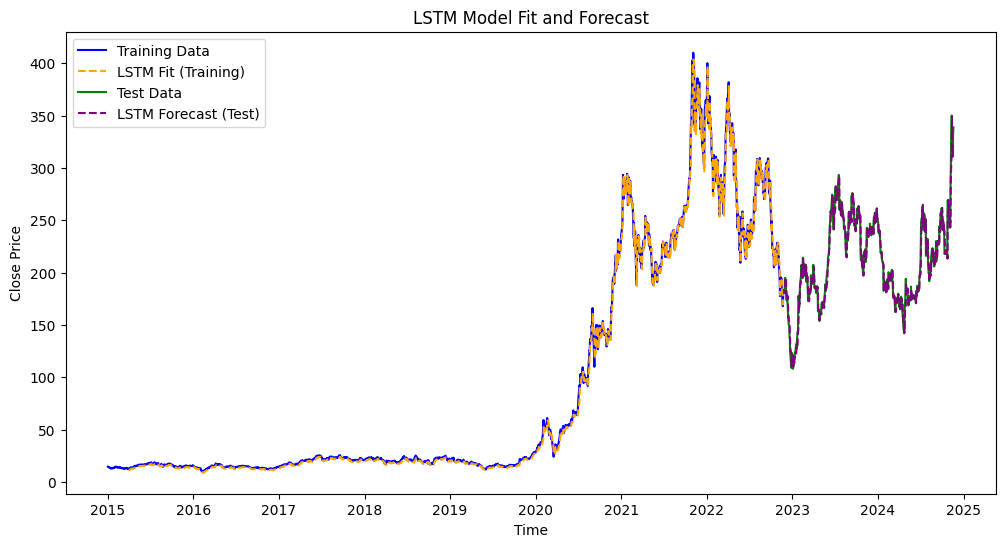

In [31]:
# Get training predictions
train_predictions = model_lstm.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)

plt.figure(figsize=(12, 6))
plt.plot(tsla_train.index, tsla_train.values, label="Training Data", color="blue")
plt.plot(tsla_train.index[60:], train_predictions.flatten(), label="LSTM Fit (Training)", linestyle="--", color="orange")
plt.plot(tsla_test.index, tsla_test.values, label="Test Data", color="green")
plt.plot(tsla_test.index, lstm_forecast.flatten(), label="LSTM Forecast (Test)", linestyle="--", color="purple")
plt.title("LSTM Model Fit and Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


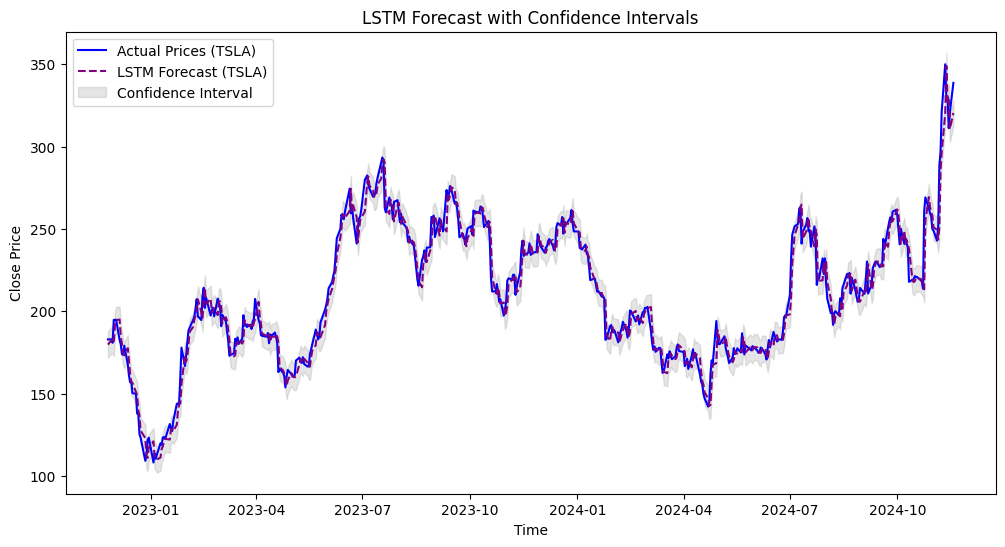

In [32]:
# Compute confidence intervals (e.g., ± standard deviation of residuals)
forecast_std = np.std(residuals)
lower_bound = lstm_forecast.flatten() - forecast_std
upper_bound = lstm_forecast.flatten() + forecast_std

plt.figure(figsize=(12, 6))
plt.plot(tsla_test.index, tsla_test.values, label="Actual Prices (TSLA)", color="blue")
plt.plot(tsla_test.index, lstm_forecast.flatten(), label="LSTM Forecast (TSLA)", linestyle="--", color="purple")
plt.fill_between(tsla_test.index, lower_bound, upper_bound, color="gray", alpha=0.2, label="Confidence Interval")
plt.title("LSTM Forecast with Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [33]:

mae = mean_absolute_error(tsla_test, lstm_forecast)
rmse = np.sqrt(mean_squared_error(tsla_test, lstm_forecast))
mape = np.mean(np.abs((tsla_test.values - lstm_forecast.flatten()) / tsla_test.values)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 5.683453785846509
Root Mean Squared Error (RMSE): 8.030528406591685
Mean Absolute Percentage Error (MAPE): 2.72%


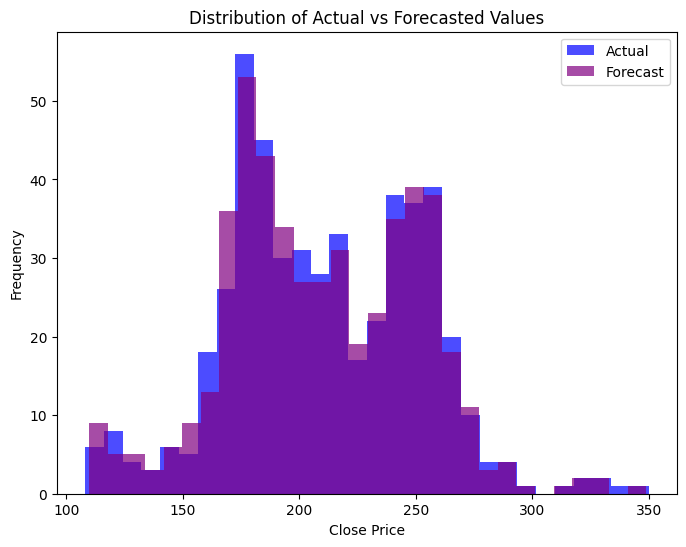

In [34]:
plt.figure(figsize=(8, 6))
plt.hist(tsla_test.values, bins=30, alpha=0.7, label="Actual", color="blue")
plt.hist(lstm_forecast.flatten(), bins=30, alpha=0.7, label="Forecast", color="purple")
plt.title("Distribution of Actual vs Forecasted Values")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Model Comparision 

In [35]:
# Evaluate models
arima_mae, arima_rmse, arima_mape = calculate_metrics(tsla_test, arima_forecast)
sarima_mae, sarima_rmse, sarima_mape = calculate_metrics(tsla_test, sarima_forecast_tsla)
lstm_mae, lstm_rmse, lstm_mape = calculate_metrics(tsla_test, lstm_forecast)

# Create a DataFrame for the metrics
metrics_data = {
    "Model": ["ARIMA", "SARIMA", "LSTM"],
    "MAE": [arima_mae, sarima_mae, lstm_mae],
    "RMSE": [arima_rmse, sarima_rmse, lstm_rmse],
    "MAPE": [arima_mape, sarima_mape, lstm_mape],
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

    Model        MAE       RMSE      MAPE
0   ARIMA  38.921688  49.702743  0.174877
1  SARIMA  40.722781  51.981066  0.181134
2    LSTM   5.683454   8.030528  0.027222
